# Predict used cars' price based on their description

## Abstract

... TODO

## Preparing the dataset

### Downloading

#### Using Kaggle's API

The dataset we are working with is from [kaggle](https://www.kaggle.com/austinreese/craigslist-carstrucks-data). To download the dataset, we can use kaggle's API command. In order to do this, we have to do the following steps.

1. Install kaggle in Anaconda.

`conda install -c conda-forge kaggle`

2. Create personal API token on the website under the account settings. After downloading, move it to the appropriate folder (Linux: ~/.kaggle/kaggle.json, Windows: C:/Users/User/.kaggle/kaggle.json).

3. Download the dataset with the API command.



In [1]:
#!kaggle datasets download -d austinreese/craigslist-carstrucks-data

4. Unzip


In [2]:
#from zipfile import ZipFile
#with ZipFile("craigslist-carstrucks-data.zip") as myzip:
#myzip.extractall("data")

#### Downloading directly

Alternatively, we can download the csv directly, unzip and copy it to the correct location.



#### Working in Google Colab

We can upload the file to Drive and link from there. To do this, we need to take the following steps.

1. Upload the file to Drive.

2. Share the file, and copy its ID.

3. In the notebook, import the following.



In [3]:
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials

4. Authenticate


In [4]:
#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)

5. Download the file from Drive

In [5]:
#downloaded = drive.CreateFile({'id':"10T9t3Kzzk4rO4Vsk3fuYpWkMj9t08_6e"})   # replace the id with id of file you want to access
#downloaded.GetContentFile('vehicles.csv')

### Preprocessing

#### Importing the dataset

Besides the obvious columns _price_ and _description_, we also need _url_ for preprocessing.

In [1]:
import pandas as pd

vehicles = pd.read_csv('./data/vehicles.csv', usecols=['url', 'price', 'description'])
vehicles.head()

,url,price,description
0,https://prescott.craigslist.org/cto/d/prescott...,6000,NaN
1,https://fayar.craigslist.org/ctd/d/bentonville...,11900,NaN
2,https://keys.craigslist.org/cto/d/summerland-k...,21000,NaN
3,https://worcester.craigslist.org/cto/d/west-br...,1500,NaN
4,https://greensboro.craigslist.org/cto/d/trinit...,4900,NaN


#### Filtering prices

If we plot the prices of the cars in a histogram, we can see that there is an overwhelming amount below $1000. Since we are talking about cars, these prices are usually incorrect. In most cases the advertiser didn't specify the price, either because they forgot, or the price is negotiable. In other cases, the advertiser made a mistake about the price, like to miss a zero. There are also cases of wrecked cars, that are only being sold for the parts, but that's out of our interest.

In the light of these observations, we decided to ignore the cars whose price is below $1000.

In the same manner, we can say that above a certain price, the values are not necessarily valid. Without filtering out too many cases, let's say the treshold is $500 000.

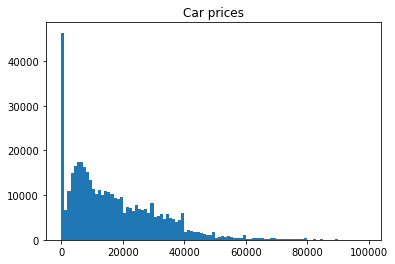

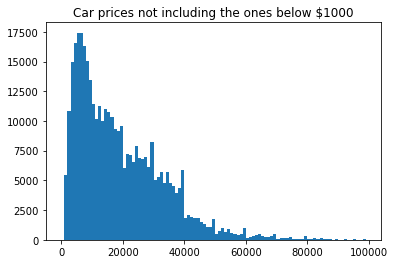

In [2]:
import matplotlib.pyplot as plt
plt.hist(vehicles['price'], bins=range(0, 100000, 1000))
plt.title("Car prices")
plt.show()
plt.hist(vehicles[vehicles.price > 1000]['price'], bins=range(0, 100000, 1000))
plt.title("Car prices not including the ones below $1000")
plt.show()
price_filtered_vehicles = vehicles[vehicles.price > 1000]
price_filtered_vehicles = price_filtered_vehicles[price_filtered_vehicles.price < 500000]

#### Filtering the descriptions

A big percentage of the advertisements belong to car dealerships, and the descriptions of these are fairly useless, since they are usually template texts, with very little useful information. So we decided to ignore those. To decide which ones are from an actual owner would be a hard task in itself, fortunately though, the url contains this information. The owners' ads are marked with "cto" while the dealers' ads are marked with "ctd".

There some ads with no descreption, we need to filter these as well.

Also, we filter the ones that are less than 100 characters, since they usually don't contain enough information.

After these filters, we are left with around 73k records, about 20% of the original dataset.

Next, we lowercase the descriptions, so they can be tokenized by the uncased version of the BERT tokenizer.

In [3]:
print("Original: "+str(len(price_filtered_vehicles)))
desc_filtered_vehicles = price_filtered_vehicles[price_filtered_vehicles.description.notnull()]
print("Not null: "+str(len(desc_filtered_vehicles)))
desc_filtered_vehicles = desc_filtered_vehicles[desc_filtered_vehicles.url.str.match(r".*/cto/.*")]
print("Owner only: "+str(len(desc_filtered_vehicles)))
desc_filtered_vehicles = desc_filtered_vehicles[desc_filtered_vehicles.description.str.len() > 100]
print("No short descriptions: "+str(len(desc_filtered_vehicles)))
print(desc_filtered_vehicles['description'].iloc[:20])
desc_filtered_vehicles['description'] = desc_filtered_vehicles['description'].apply(lambda x: x.lower())
print(desc_filtered_vehicles['description'].iloc[:20])

Original: 379288
Not null: 379227
Owner only: 81538
No short descriptions: 73600
34     Selling my 2019 Toyota Tacoma TRD Off Road Dou...
37     192k miles brand new TSLs 4x4 jeep xj. 4x4 wor...
55     Here I have a unmolested Ford F-250 6.0 power ...
59     Readily available. Excellent condition, clean ...
65     Ford Super Duty F450 , XL with King Ranch seat...
86     2004 Chrysler Town & Country Touring. Seats 7....
95     Looking to sell my 2006 Subaru Impreza hatchba...
101    Looking to find a good Volvo 1800S or 1800ES w...
110    2003 Chrysler Town and Country Handicapped Acc...
119    Aspects: -Goodyear Wrangler Tires: 33’s  -Catt...
120    Diesel engine Mercedes e class. 7 speed auto t...
122    2005 Blue Bird 12 window, 72 passenger bus tha...
137    Great Chevy Barn Find  Great candidate for res...
138    2006 Jeep Grand Cherokee Laredo FOR SALE BY OW...
159    2017 Subaru Forester 2.5i Premium in excellent...
160    bought from King Acura in Birmingham certified...
171    

## Training

### Using DistilBERT and fine-tuning it


For this project we will use only a small portion of the dataset, because it takes a lot of memory and CPU time to train the model.

In [4]:
batch_0 = desc_filtered_vehicles.iloc[:500]

In [5]:
#!pip install transformers

In [35]:
import numpy as np
import torch
import transformers
import seaborn as sns
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch import nn
from collections import defaultdict

Loading DistilBERT.

In [96]:
model_class = transformers.DistilBertModel
tokenizer_class = transformers.DistilBertTokenizer
pretrained_weights = 'distilbert-base-uncased'
#model_class = transformers.BertModel
#tokenizer_class = transformers.BertTokenizer
#pretrained_weights = 'bert-base-uncased'

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Let's see how many tokens does each description have. As we can see, most of them are less than 300 tokens long. We can chose the maximum length to be 256 without sacrificing too much information.

C:\Users\Tofi\miniconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


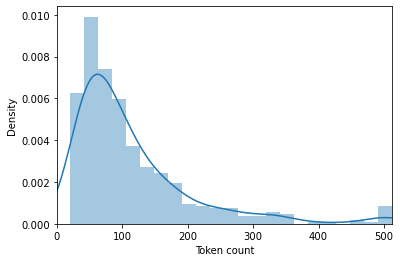

In [47]:
token_lens = []
for txt in batch_0['description']:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))
sns.distplot(token_lens)
plt.xlim([0, 512]);
plt.xlabel('Token count');

Let's define a dataset class for our cars, that extends the Dataset class from pytorch. This will make reading it easier.

In [62]:
class VehiclesDataset(Dataset):
    def __init__(self, descriptions, prices, tokenizer, max_len):
        self.descriptions = descriptions
        self.prices = prices
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.descriptions)
    def __getitem__(self, item):
        description = str(self.descriptions[item])
        price = self.prices[item]
        encoding = self.tokenizer.encode_plus(
            description,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'description_text': description,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'prices': torch.tensor(price, dtype=torch.float)
        }

Splitting the dataset into train, dev, and test parts.

In [63]:
RANDOM_SEED = 1
df_train, df_test = train_test_split(
  batch_0,
  test_size=0.1,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)
df_train.shape, df_val.shape, df_test.shape

((450, 3), (25, 3), (25, 3))

We also define a data loader alongside our dataset.

In [64]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = VehiclesDataset(
        descriptions=df['description'].to_numpy(),
        prices=df['price'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )


Creating a data loader for each set.

In [65]:
MAX_LEN = 256
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [66]:
#data = next(iter(train_data_loader))
#data.keys()


dict_keys(['description_text', 'input_ids', 'attention_mask', 'prices'])

In [67]:
#print(data['input_ids'].shape)
#print(data['attention_mask'].shape)
#print(data['prices'].shape)

torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])


#### Our model

The model consists of the BERT model itself, a dropout part, and a final layer, with only one output as the predicted price. The dropout is supposed to be there to avoid overfitting.

In [68]:
class PriceGuesser(nn.Module):
    def __init__(self):
        super(PriceGuesser, self).__init__()
        self.bert = model_class.from_pretrained(pretrained_weights)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, 1)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        output = self.drop(outputs.last_hidden_state[:,0,:])
        return self.out(output)

In [69]:
model = PriceGuesser()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [70]:
#input_ids = data['input_ids']
#attention_mask = data['attention_mask']
#print(input_ids.shape) # batch size x seq length
#print(attention_mask.shape) # batch size x seq length

torch.Size([16, 256])
torch.Size([16, 256])


### Training

We did not really change BERT's recommended parameters, but for the loss function, we used the root mean square error function, which is good for regression tasks.

In [76]:
EPOCHS = 3
optimizer = transformers.AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
loss_fn = nn.MSELoss()

We defined two functions, one for the training, and another for evaluating the model with the dev set.

In [77]:
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    scheduler,
    n_examples
):
    model = model.train()
    correct_predictions = 0
    for d in data_loader:
        input_ids = d["input_ids"]
        attention_mask = d["attention_mask"]
        prices = d["prices"]
        output = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        loss = torch.sqrt(loss_fn(output, prices))
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return loss

In [80]:
def eval_model(model, data_loader, loss_fn, n_examples):
    model = model.eval()
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"]
            attention_mask = d["attention_mask"]
            prices = d["prices"]
            output = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            loss = torch.sqrt(loss_fn(output, prices))
    return loss

Finally, here is the training loop itself. Running this took a lot of time and memory, so there might be something we overlook in the setup process. Even so that the result didn't really improve at all through the epochs.

In [81]:
%%time
history = defaultdict(list)
least_loss = 100000
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        scheduler,
        len(df_train)
    )
    print(f'Train loss {train_loss}')
    val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        len(df_val)
    )
    print(f'Val   loss {val_loss}')
    print()
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    if val_loss < least_loss:
        torch.save(model.state_dict(), 'best_model_state.bin')
        least_loss = val_loss

Epoch 1/3
----------
Train loss 5487.30859375


C:\Users\Tofi\miniconda3\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([9])) that is different to the input size (torch.Size([9, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val   loss 16347.4306640625

Epoch 2/3
----------
Train loss 5487.35595703125
Val   loss 16347.2900390625

Epoch 3/3
----------


KeyboardInterrupt: 

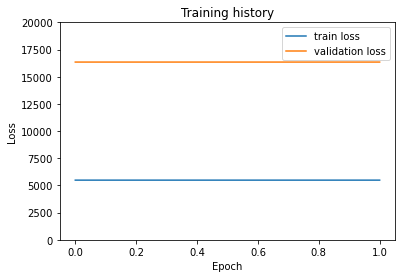

In [84]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 20000]);

### Using just the pre-trained BERT model

We tried to train without fine-tuning the model, using an SGD regression at the end.

In [97]:
tokenized = batch_0['description'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=256, truncation=True)))

In [98]:
max_len = 256

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
np.array(padded).shape

(500, 256)

In [99]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(500, 256)

In [100]:
input_ids = torch.tensor(padded)
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [101]:
features = last_hidden_states[0][:,0,:].numpy()

In [104]:
labels = batch_0['price']

In [105]:
Xtrain, Xtest, ytrain, ytest = train_test_split(features, labels, test_size=0.2, random_state=0)
print(Xtrain.shape)
print(ytrain.shape)

(400, 768)
(400,)


In [106]:
regr = SGDRegressor(max_iter=10000)
regr.fit(Xtrain, ytrain)

SGDRegressor(max_iter=10000)

Here is the result, the prediction (in yellow) compared to the actual prices (in blue).

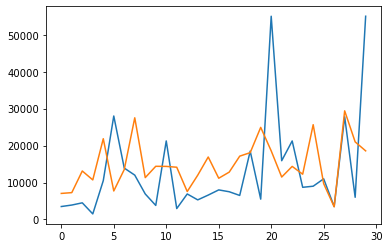

In [113]:
plt.plot(ytest.iloc[0:30].tolist())
plt.plot(regr.predict(Xtest)[0:30].tolist())

The root mean square error of the simple model:

In [114]:
from sklearn.metrics import mean_squared_error

rms = mean_squared_error(ytest, regr.predict(Xtest), squared=False)
rms

10189.141773038533

In [91]:
#ID = 200
#print(df_train.iloc[ID]['description'])
#print(df_train.iloc[ID]['price'])

2011 gmc 2500 duramax truck for sale, has allison transmission 4x4 slt z71 crew cab. super nice! comes with leather seats, duel power seats, heated seats, adjustable pedals, power windows and door locks, backup cam, towing package, trailer brakes, keyless entry, cruise control, cold ac, good heat, tool box, bed rails, in bed liner, sprayed. michelin tires, super nice truck and more. 27,900.00 call larry  show contact info
27900


## References

The model is based on this tutorial:
[https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/]

And this one: https://github.com/jalammar/jalammar.github.io/blob/master/notebooks/bert/A_Visual_Notebook_to_Using_BERT_for_the_First_Time.ipynb

There was some important information in this question: https://stackoverflow.com/questions/15087322/how-to-predict-a-continuous-value-time-from-text-documents/

